In [80]:
!pip install tensorflow_similarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
import tensorflow as tf
import tensorflow_similarity as tfsim 
from mpl_toolkits import axes_grid1
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
tfsim.utils.tf_cap_memory()

In [83]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=6, color=True,resize=1.0) 

In [84]:
num_class=len(faces.target_names)
num_image=len(faces.images)

In [85]:
print('number of images is:',num_image)
print('number of persons is:',num_class)

number of images is: 5425
number of persons is: 311


In [86]:
for i in range(num_class):
  if faces.target_names[i]=='David Beckham': print(i)

57


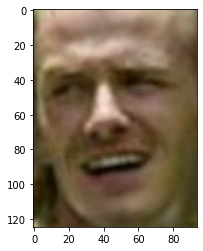

In [87]:
j=0
for i in range(num_image):
  if faces.target[i]==57: plt.imshow(faces.images[i].astype('uint8'))

In [88]:
mask = np.zeros(faces.target.shape, dtype=np.bool)
 
for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:50]] = 1
 
x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], faces.images.shape[3]))
print('number of images is:',x_faces.shape[0])

number of images is: 4465


<ipython-input-88-66050d971e39>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(faces.target.shape, dtype=np.bool)


In [89]:
np.shape(faces.images)

(5425, 125, 94, 3)

In [90]:
import cv2
x_faces_resized = np.zeros((x_faces.shape[0],48,48,3))
for i in range(x_faces.shape[0]):
    x_faces_resized[i,:,:,:] = cv2.resize(x_faces[i,:,:,:], (48,48), interpolation = cv2.INTER_AREA)

x_faces_resized.shape


(4465, 48, 48, 3)

In [91]:

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
 
face_images = preprocess_input(np.array(x_faces_resized))
face_labels = to_categorical(y_faces)
x_train, x_test, y_train, y_test = train_test_split(face_images, y_faces, train_size=0.8, stratify=y_faces, random_state=0)
print('shape of training data:',x_train.shape,'shape of test data',x_test.shape, y_train.shape, y_test.shape)

shape of training data: (3572, 48, 48, 3) shape of test data (893, 48, 48, 3) (3572,) (893,)


In [92]:
face_images.shape

(4465, 48, 48, 3)

In [93]:
ms_classes_per_batch = 50
ms_examples_per_class_per_batch = 4

train_ds = tfsim.samplers.MultiShotMemorySampler(
    x_train,
    y_train,
    classes_per_batch= ms_classes_per_batch,
    examples_per_class_per_batch=ms_examples_per_class_per_batch,
    class_list=list(y_train)
)

test_ds = tfsim.samplers.MultiShotMemorySampler(
    x_test,
    y_test,
    classes_per_batch= ms_classes_per_batch,
    total_examples_per_class=4
)


The initial batch size is 200 (50 classes * 4 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/3572 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/311 [00:00<?, ?it/s]

gather examples:   0%|          | 0/3572 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/3572 [00:00<?, ?it/s]


The initial batch size is 100 (50 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/893 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/311 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1244 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/1244 [00:00<?, ?it/s]

In [94]:
len(faces.target_names)

311

In [95]:
base_cnn = resnet.ResNet50(weights="imagenet", input_shape=(48, 48, 3) , include_top=False)
for layer in base_cnn.layers:
    layer.trainable = False
    if layer.name == "conv5_block1_out":
      layer.trainable = True

In [96]:
import tensorflow.keras.applications as models

def triplet_model():
    flatten = tf.keras.layers.Flatten()(base_cnn.output)
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255)(flatten)
    output = tf.keras.layers.Dense(128)(x)
    outputs = tfsim.layers.MetricEmbedding(128)(output)
   # outputs= tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output) # L2 normalize embeddings

    return tfsim.models.SimilarityModel(base_cnn.input, outputs)


t_model = triplet_model()
t_model.summary()

Model: "similarity_model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                 

In [97]:
from tensorflow.python import metrics
import tensorflow_addons as tfa
epochs = 5
#loss=tfa.losses.TripletSemiHardLoss(distance_metric='L2')
loss = tfsim.losses.TripletLoss(distance='L2',positive_mining_strategy='hard',negative_mining_strategy='semi-hard',margin=0.8)
#loss = tfsim.losses.TripletLoss()
t_model.compile(optimizer=tf.keras.optimizers.Adam(),
    loss=loss)
history = t_model.fit(
    train_ds, epochs=epochs, validation_data=test_ds)

Distance metric automatically set to euclidean use the distance arg to override.
Epoch 1/5
1000/1000 [==============================] - 98s 94ms/step - loss: 0.4138 - val_loss: 0.3551
Warmup complete
Epoch 2/5
1000/1000 [==============================] - 94s 94ms/step - loss: 0.1147 - val_loss: 0.3541
Epoch 3/5
1000/1000 [==============================] - 94s 94ms/step - loss: 0.0572 - val_loss: 0.3586
Epoch 4/5
1000/1000 [==============================] - 94s 94ms/step - loss: 0.0310 - val_loss: 0.3598
Epoch 5/5
1000/1000 [==============================] - 94s 94ms/step - loss: 0.0147 - val_loss: 0.3574


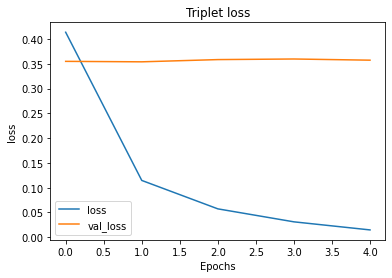

In [98]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title("Triplet loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

In [99]:
y_test_listed = y_test.tolist()
new_sorted = sorted(set(y_test_listed), key = lambda ele: y_test_listed.count(ele), reverse=True)

masked = np.zeros(y_test.shape, dtype=np.bool) 
num_examples_to_clusters = 5
for target in range(num_examples_to_clusters):
    masked[np.where(y_test == new_sorted[target+8])[0][:8]] = 1

new_vx = x_test[masked]
new_vy = y_test[masked]

thumb_size = 100
plot_size = 400
tfsim.visualization.projector(
    t_model.predict(new_vx), labels=new_vy, images=new_vx, image_size=thumb_size, plot_size=plot_size, pt_size=8
)

<ipython-input-99-dc2ac45fcd38>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masked = np.zeros(y_test.shape, dtype=np.bool)


2/2 [==============================] - 1s 13ms/step
perfoming projection using UMAP


generating diplayabe images:   0%|          | 0/40 [00:00<?, ?it/s]

In [100]:
index_size = 1244
begin = 0
index_x, index_y = test_ds.get_slice(begin, index_size)
t_model.reset_index()
t_model.index(index_x , index_y, data=index_x)
calibration = t_model.calibrate(
    x_test,
    y_test,
    calibration_metric="f1",
    matcher="match_nearest",
    extra_metrics=["precision", "recall", "binary_accuracy"],
    verbose=1)

[Indexing 1244 points]
|-Computing embeddings
39/39 [==============================] - 1s 16ms/step
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.
28/28 [==============================] - 0s 13ms/step

Performing NN search



Building NN list:   0%|          | 0/893 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]


 name        value    distance    precision    recall    binary_accuracy        f1
-------  --------  ----------  -----------  --------  -----------------  --------
optimal  0.973684    0.515124     0.998413  0.950151           0.704367  0.973684


In [101]:
y_train_listed = y_train.tolist()
new_sorted = sorted(set(y_train_listed), key = lambda ele: y_train_listed.count(ele), reverse=True)

masked = np.zeros(y_train.shape, dtype=np.bool) 
num_examples_to_clusters = 5
for target in range(num_examples_to_clusters):
    masked[np.where(y_train == new_sorted[target])[0][:8]] = 1

new_vx = x_train[masked]
new_vy = y_train[masked]

thumb_size = 100
plot_size = 400
tfsim.visualization.projector(
    t_model.predict(new_vx), labels=new_vy, images=new_vx, image_size=thumb_size, plot_size=plot_size, pt_size=8
)

2/2 [==============================] - 0s 12ms/step
perfoming projection using UMAP


<ipython-input-101-bd54ad260426>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masked = np.zeros(y_train.shape, dtype=np.bool)


generating diplayabe images:   0%|          | 0/40 [00:00<?, ?it/s]